In [93]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [12]:
airline_tweets.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [13]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


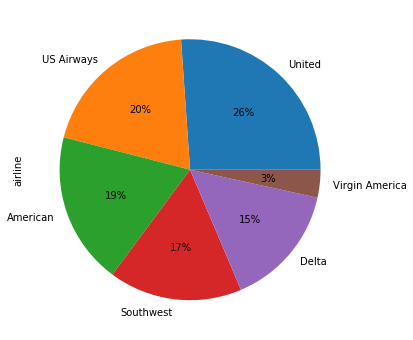

In [14]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

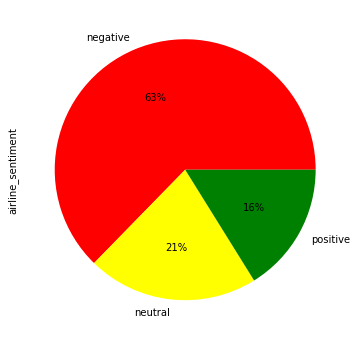

In [15]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

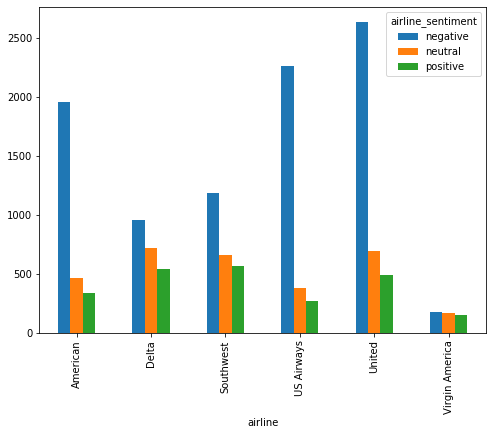

In [16]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

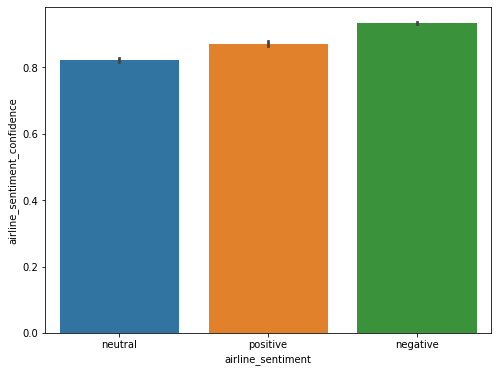

In [17]:
import seaborn as sns

sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)

In [18]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [19]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    #processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [20]:
X_train[0:2]

[' JetBlue yes thankfully Catering just got here and now they are loading but very frustrated was supposed to be there by 10 10 30',
 ' united yes have amp they re unsure when it would come This has never happened on any airline and my first time with united disappointed']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [115]:
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best training params:  {'C': 0.3}
Best training Score:  0.799863387978142
Best training Score:  LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.17, 0.19, 0.25]), 'std_fit_time': array([0.01, 0.02, 0.01]), 'mean_score_time': array([0.01, 0.  , 0.  ]), 'std_score_time': array([0., 0., 0.]), 'param_C': masked_array(data=[0.1, 0.3, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 0.3}, {'C': 1}], 'split0_test_score': array([0.79, 0.8 , 0.8 ]), 'split1_test_score': array([0.78, 0.8 , 0.8 ]), 'split2_test_score': array([0.79, 0.81, 0.8 ]), 'mean_test_score': array([0.79, 0.8 , 0.8 ]), 'st

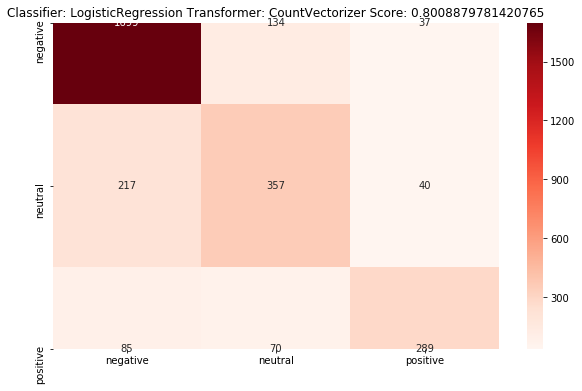

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {}
Best training Score:  0.752988387978142
Best training Score:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Full results from grid search:  {'mean_fit_time': array([0.03]), 'std_fit_time': array([0.]), 'mean_score_time': array([0.01]), 'std_score_time': array([0.]), 'params': [{}], 'split0_test_score': array([0.76]), 'split1_test_score': array([0.75]), 'split2_test_score': array([0.75]), 'mean_test_score': array([0.75]), 'std_test_score': array([0.]), 'rank_test_score': array([1], dtype=int32)}
Best results from grid search:  {}
Classifier: MultinomialNB Transformer: CountVectorizer
F1 score (micro):  0.7739071038251366
F1 score (macro):  0.6624011326360226
Accuracy score:  0.7739071038251366


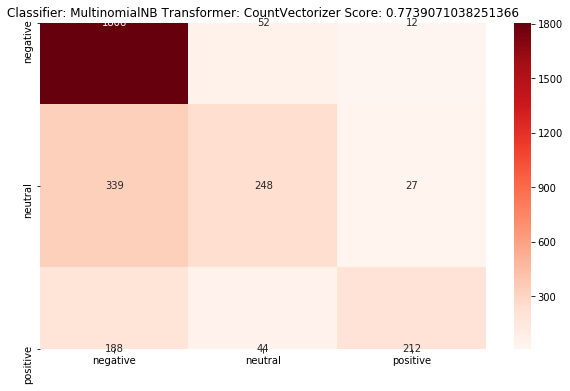

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {'max_depth': 20, 'n_estimators': 10}
Best training Score:  0.6385758196721312
Best training Score:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.02, 0.04, 0.06, 0.02, 0.06, 0.09, 0.03, 0.16, 0.23, 0.04, 0.32,
       0.47]), 'std_fit_time': array([0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ]), 'mean_score_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.  , 0.01,
       0.01]), 'std_score_time': array([4.85e-04, 4.53

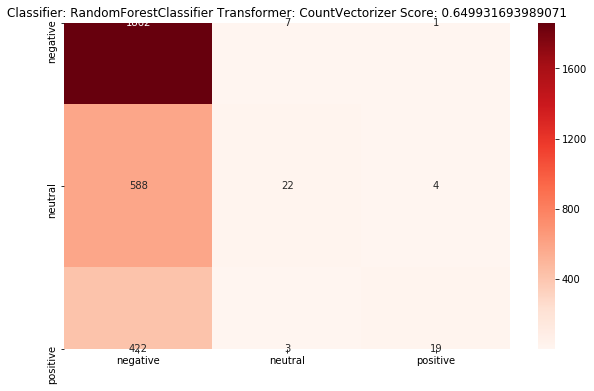

ValueError: Expected 2D array, got 1D array instead:
array=[' JetBlue yes thankfully Catering just got here and now they are loading but very frustrated was supposed to be there by 10 10 30'
 ' united yes have amp they re unsure when it would come This has never happened on any airline and my first time with united disappointed'
 ' united Wife and have two new destinations and m stuck in DC until Monday with no bags'
 ... ' usairways the Worst Ever dca customerservice'
 ' nrhodes85 look Another apology DO NOT FLY USAirways'
 ' united you are by far the worst airline 4 plane delays on 1 round trip flight How is that possible '].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [134]:
#Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

import itertools

from sklearn.pipeline import make_pipeline
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

transformers = [CountVectorizer(), TfidfTransformer()]
classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier()]
hyperparameters = {
    "RandomForestClassifier": {"n_estimators": [1, 10, 15], "max_depth": [1,3,10,20]},
    "LogisticRegression": {"C": [0.1, 0.3, 1]},
    "MultinomialNB": {}
}

results = {}

for transformer in transformers:
    transformer.fit(X_train, y_train)
    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        classifier = GridSearchCV(classifier, hyperparameters[classifier.__class__.__name__])
        pipeline = make_pipeline(transformer, classifier)
        
        classifier.fit(transformer.transform(X_train), y_train)
        
        print(f"Best training params: ", classifier.best_params_)
        print(f"Best training Score: ", classifier.best_score_)
        print(f"Best training Score: ", classifier.best_estimator_)
        
        best_classifier = classifier.best_estimator_
        
        y_pred      = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        
        test_score = accuracy_score(y_test, y_pred_test)
        
        results[pipeline] = test_score
        
        #plot_confusion_matrix(y_test, y_pred_test, classes = classifier.classes_)
        cm = confusion_matrix(y_test, y_pred_test)  
        index = classifier.classes_
        columns = classifier.classes_
        cm_df = pd.DataFrame(cm,columns,index)                      
        plt.figure(figsize=(10,6))  
        sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'Reds')
        print("Full results from grid search: ", classifier.cv_results_)
        print("Best results from grid search: ", classifier.best_params_)

        print(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__}")

        print(f"F1 score (micro): ", f1_score(y_test, y_pred_test, average='micro'))
        print(f"F1 score (macro): ", f1_score(y_test, y_pred_test, average='macro'))
        print(f"Accuracy score: ", accuracy_score(y_test, y_pred_test))
        
        plt.title(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__} Score: {test_score}")
        plt.show()
        